# Data 

In [25]:
# Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import numpy.random as rnd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

In [2]:
data = pd.read_csv("data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


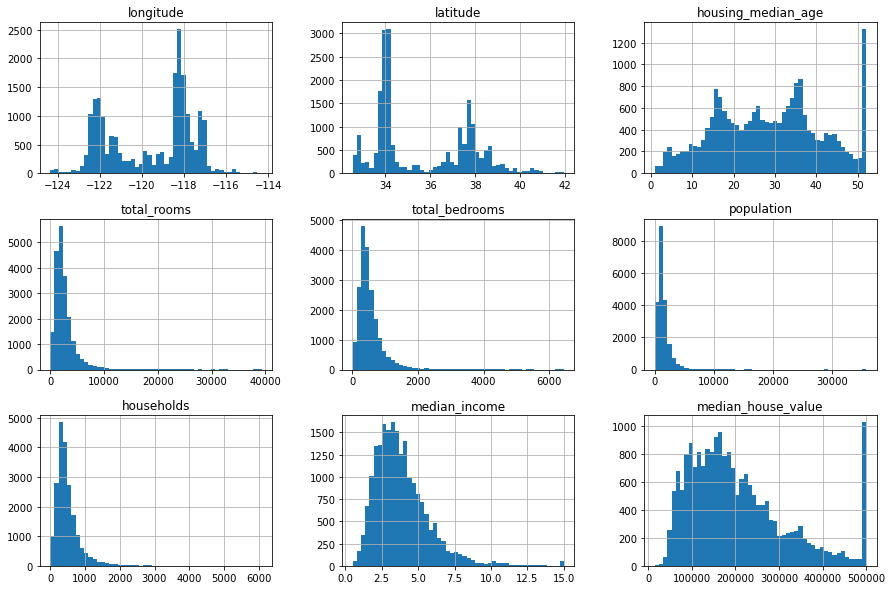

In [6]:
data.hist(bins=50, figsize=(15,10))
plt.savefig("data/images/histograms.png")
plt.show()

# Stratified Sampling

### Most of the median income clusters around 1.5 to 6.0. 

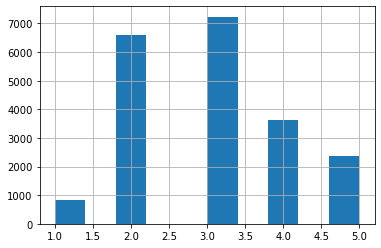

In [7]:
data['income_cat'] = pd.cut(data['median_income'], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
data['income_cat'].hist()
plt.show()

### Stratified Sampling is used to divide the population into various subsets and treat each subset as a separate population. We performed stratified sampling based on the income category above. 

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


### We remove the income category attribute to get the data back to its original form.

In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
housing = strat_train_set.copy()

### Visualize the dataset based on geographical locations 

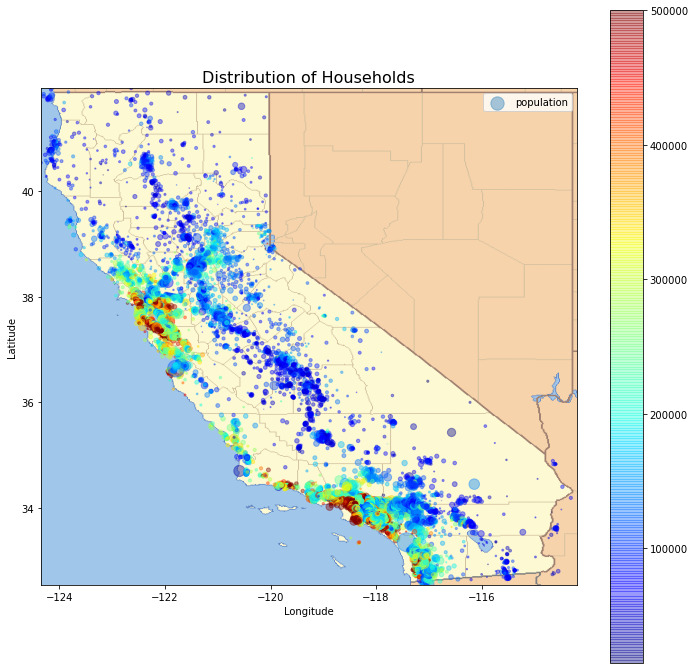

In [21]:
plt.figure(figsize=(12,12))
img=plt.imread("data/california.png")
plt.imshow(img, zorder=0, extent=[-124.35,-114.2,32.54,41.95])

plt.scatter(x=data['longitude'], y=data['latitude'], alpha=0.4, s=data['population']/100, label='population',
         c=data['median_house_value'], cmap=plt.get_cmap('jet'), zorder=1)
plt.colorbar()
plt.title("Distribution of Households", size=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("data/images/CA.png")

### The red marks represent the most expensive locations while the blue marks represents the more cheaper locations. The larger circles indicate areas with a larger population. It can be inferred that housing prices are related to the location and the population density. 

# Correlations

### Calculate the standard correlation coefficient between each pair of attributes

In [22]:
corr_matrix = data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### The closer the correlation coefficient is to 1 shows that there is a positive correlation. The closer the correlation coefficient is to -1 shows that there is a negative correlation. When it is close to 0, it means that there is no linear correlation.

### This visualizes the attributes that are likely to be correlated. 

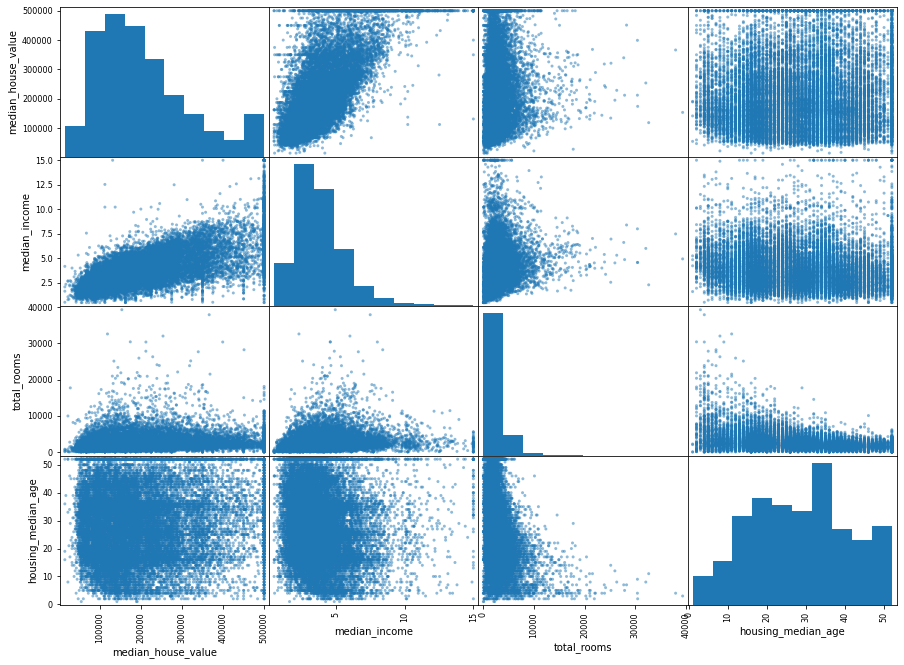

In [29]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(data[attributes], figsize=(15,11))
plt.savefig("data/images/scatter_matrix_plot.png")

### The correlation between median_income and median_house_value is the strongest. The correlation matrix shows that the correlation coefficient is 0.688075. The second graph in the first row in the above scatter matrix shows the positive correlation between these two attributes and that the price caps out at 500k. 

### We then created the following new attributes: number of rooms per household, bedrooms per rooms, population per household.

In [32]:
data["rooms_per_household"] = data["total_rooms"]/data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"]
data["population_per_household"] = data["population"]/data["households"]

In [33]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_household     -0.255880
Name: median_house_value, dtype: float64